# makemore, but made with an MLP (Multi-Layer Perceptron)


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    torch.set_default_device(mps_device)

In [2]:
# read in all the words
words = open("names.txt", "r").read().splitlines()
words[:8]  # show first 8 words

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)  # how many words do we have?

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))  # unique characters in the words
stoi = {s: i + 1 for i, s in enumerate(chars)}  # string to integer mapping
stoi["."] = 0  # add a special end-of-word character
itos = {i: s for s, i in stoi.items()}  # integer to string mapping
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Buiding the dataset


In [5]:
block_size = (
    3  # Context length: how many characters do we take to predict the next character?
)
X, Y = [], []  # input and output arrays
for w in words:
    # print(f'word: {w}')
    context = [0] * block_size
    for ch in w + ".":
        ix = stoi[ch]  # convert character to integer
        X.append(context)  # append the context
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '-->', itos[ix])
        context = context[1:] + [ix]  # slide the window, add new character

X = torch.tensor(X)  # convert to tensor
Y = torch.tensor(Y)  # convert to tensor

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
# Building the dataset

def build_dataset(words, block_size = 3):
    # The block size determines how many previous characters we consider to predict the next character.
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    return torch.tensor(X), torch.tensor(Y)

import random
random.seed(42)  # for reproducibility
random.shuffle(words)  # shuffle the words to ensure randomness
n1 = int(0.8 * len(words))  # 80% for training
n2 = int(0.9 * len(words))  # 10% for validation

X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

In [8]:
# Lookup Table
C = torch.randn((27, 2))

In [9]:
emb = C[X]
emb.shape  # shape of the embedding tensor

torch.Size([228146, 3, 2])

In [10]:
W1 = torch.randn((6, 100))  # weights for the first layer
b1 = torch.randn(100)  # bias for the first layer

In [11]:
# torch.cat(torch.unbind(emb, 1), dim=1).shape
h = torch.tanh(
    emb.view(emb.shape[0], -1) @ W1 + b1
)  # apply linear transformation and activation

In [12]:
h

tensor([[-0.9999,  0.9994,  0.9845,  ..., -0.9947, -0.4768,  0.8794],
        [-0.9950,  0.5928,  0.9214,  ..., -0.1221,  0.9406,  0.6245],
        [-0.9990,  0.9117,  0.4142,  ..., -0.9998,  0.9793,  0.6254],
        ...,
        [-0.9456,  0.1861, -0.4792,  ..., -0.8897,  0.9547,  0.9011],
        [-0.9995,  0.8286,  0.9239,  ..., -0.8644,  0.7431,  0.8758],
        [ 0.9980, -0.9988, -0.8699,  ...,  0.9899,  0.9980,  0.4247]],
       device='mps:0')

In [13]:
h.shape

torch.Size([228146, 100])

In [14]:
W2 = torch.randn((100, 27))  # weights for the output layer
b2 = torch.randn(27)  # bias for the output layer

In [15]:
logits = h @ W2 + b2  # compute logits for the output layer

In [16]:
logits.shape

torch.Size([228146, 27])

In [17]:
counts = logits.exp()  # convert logits to counts (unnormalized probabilities)

In [18]:
prob = counts / counts.sum(1, keepdim=True)  # normalize to get probabilities

In [19]:
prob.shape

torch.Size([228146, 27])

In [20]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [21]:
num_neurons = 256
g = torch.Generator(device=mps_device).manual_seed(
    2147483647
)  # set random seed for reproducibility
C = torch.randn(
    (27, 16), generator=g
)  # reinitialize the lookup table with the same seed
W1 = torch.randn((48, num_neurons), generator=g)  # reinitialize weights
b1 = torch.randn(num_neurons, generator=g)  # reinitialize biases for the first layer
W2 = torch.randn((num_neurons, 27), generator=g)  # reinitialize weights for the output layer
b2 = torch.randn(27, generator=g)  # reinitialize biases for the output layer
parameters = [C, W1, b1, W2, b2]  # list of parameters

In [22]:
sum(p.nelement() for p in parameters)

19915

In [23]:
for p in parameters:
    p.requires_grad = True  # enable gradients for all parameters

In [24]:
# Exponentially linearly spaced learning rates
steps = 384000
# lre = torch.linspace(-3, 0, steps)
lre = torch.linspace(-1.75, -0.25, steps)
lrs = 10**lre

In [25]:
#  Forward pass
X_train, Y_train = X_train.to(mps_device), Y_train.to(mps_device)  # move
# learning_rate = -0.25  # learning rate for the optimizer
lri = []
lossi = []
stepi = []
batch_size = 512  # size of the mini-batch


2.0138344764709473


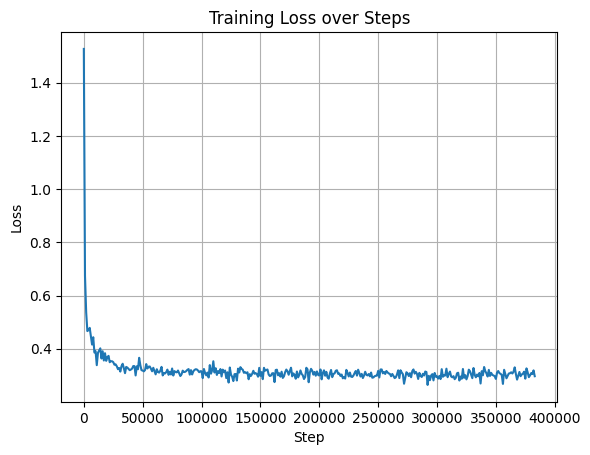

In [26]:

for i in range(steps):
    # Construct Mini-batch
    ix = torch.randint(0, X_train.shape[0], (batch_size,))

    emb = C[X_train[ix]]  # get embeddings for the input characters
    h = torch.tanh(
        emb.view(emb.shape[0], -1) @ W1 + b1
    )  # apply linear transformation and activation
    logits = h @ W2 + b2  # compute logits for the output layer
    # counts = logits.exp()  # convert logits to counts (unnormalized probabilities)
    # prob = counts / counts.sum(1, keepdim=True)  # normalize to get probabilities
    # loss = -prob[torch.arange(32), Y].log().mean()  # compute the log probability of the true labels
    loss = F.cross_entropy(
        logits, Y_train[ix]
    )  # equivalent loss using PyTorch's built-in function

    # Backward pass
    for p in parameters:
        p.grad = None  # zero out gradients

    loss.backward()  # compute gradients
    # Update parameters
    # lr = lrs[i]
    lr = 0.1
    if i > steps / 2:
        lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad  # update parameters using gradient descent

    # Track stats
    # lri.append(lre[i].cpu())
    if i % 1000 == 0:
        lossi.append(loss.log10().item())
        stepi.append(i)

print(loss.item())  # print the loss value
# plt.plot(lri, lossi)
plt.plot(stepi, lossi)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.grid()
plt.show()

## Dev Set Loss

In [27]:
emb = C[X_dev]  # get embeddings for the input characters
h = torch.tanh(
    emb.view(emb.shape[0], -1) @ W1 + b1
)  # apply linear transformation and activation
logits = h @ W2 + b2  # compute logits for the output layer
loss = F.cross_entropy(logits, Y_dev)
loss

tensor(2.1359, device='mps:0', grad_fn=<NllLossBackward0>)

## Training set loss

In [28]:
emb = C[X_train]  # get embeddings for the input characters
h = torch.tanh(
    emb.view(emb.shape[0], -1) @ W1 + b1
)  # apply linear transformation and activation
logits = h @ W2 + b2  # compute logits for the output layer
loss = F.cross_entropy(logits, Y_train)
loss

tensor(2.0038, device='mps:0', grad_fn=<NllLossBackward0>)

### Training the model on the entirety of the data for all passes will lead to a very large training time, so we will use batches of data for training

It is generally better to train smaller batches of data though the gradient is not as accurate, but its better to take many small steps than a few large steps.
### Training split, dev/validation split, test split
### 80%. 10%, 10% split


Since the training and dev set lossi are very similar, we can assume that the model is not overfitting and is generalizing well to the dev set.
This model is not powerful enough to learn the patterns in the data/purely memorizing the data, so we can safely increase the size of the model by increasing the number of hidden units in the first layer, or by adding more layers to the model to improve the performance of the model.

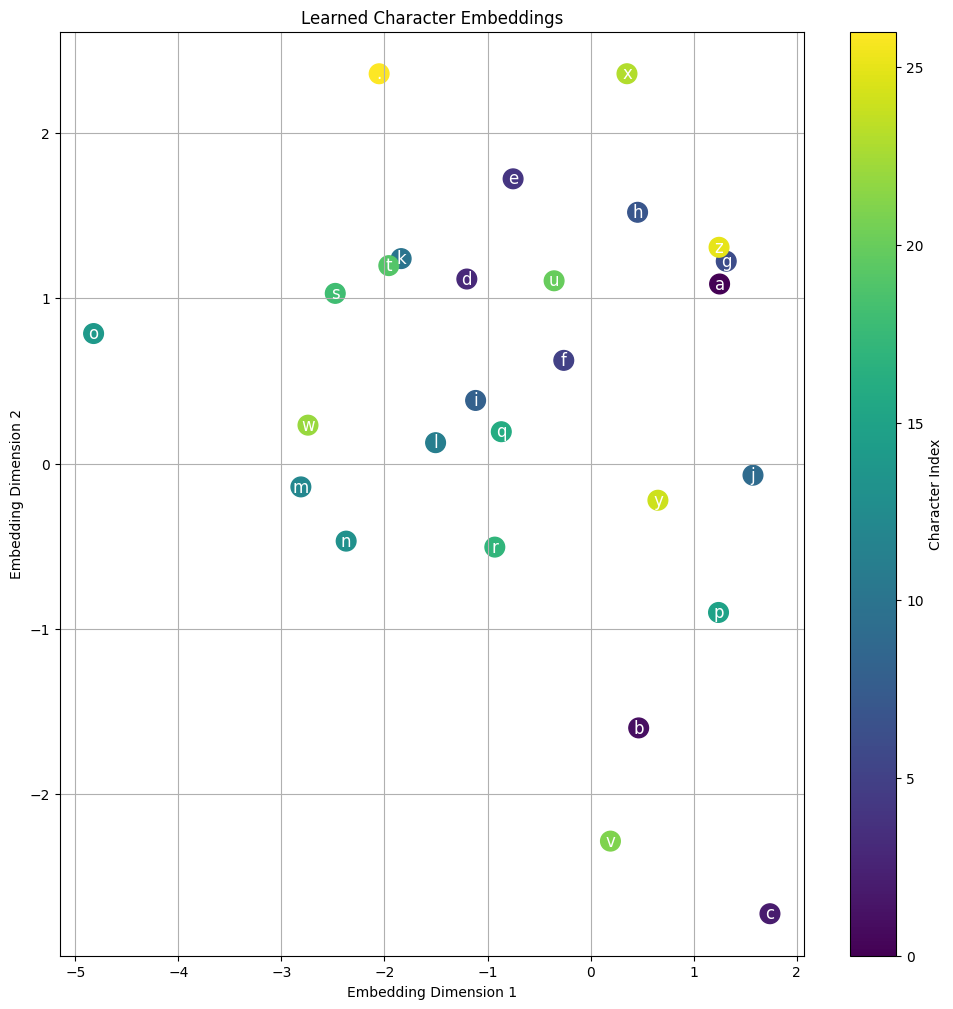

In [30]:
# # Visualise the learned embeddings
plt.figure(figsize=(12, 12))
plt.scatter(
    C[:, 0].detach().cpu().numpy(),
    C[:, 1].detach().cpu().numpy(),
    s=200,
    c=range(len(C)),
    cmap='viridis',
)
for i, ch in enumerate(itos.values()):
    plt.text(
        C[i, 0].item(),
        C[i, 1].item(),
        ch,
        fontsize=12,
        ha='center',
        va='center',
        color='white',
    )
plt.title("Learned Character Embeddings")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.colorbar(label='Character Index')
plt.grid()
plt.show()
